In [6]:
%cd /Users/gwg/dmcm
%matplotlib inline

/Users/gwg/dmcm


In [7]:
import numpy as np
import torch
import random
import matplotlib
import matplotlib.pyplot as plt
from   PIL import Image

from   data import MnistConfig, MnistDataset, loader
from   models import DCCA

In [8]:
cfg = MnistConfig()

In [11]:
path = '/Users/gwg/dmcm/experiments/20190115_dcca_baseline/'\
       'mnist_mode-dcca_batch_size-128_seed-0_latent_dim-2_lr-0.0001_l1_coef-0.0_private_z-1/'\
       'model.pt'

print(path)
    
state = torch.load(path, map_location={'cuda:0': 'cpu'})
cfg.IMG_EMBED_DIM = cfg.GENE_EMBED_DIM = 2
model = DCCA(cfg)
model.load_state_dict(state)

/Users/gwg/dmcm/experiments/20190115_dcca_baseline/mnist_mode-dcca_batch_size-128_seed-0_latent_dim-2_lr-0.0001_l1_coef-0.0_private_z-1/model.pt


In [12]:
train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    cv_pct=0.1)
dataset = MnistDataset(cfg)

In [13]:
inds = test_loader.sampler.indices
n    = len(inds)

X1 = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
X2 = torch.Tensor(n, cfg.N_GENES)
labels = torch.Tensor(n)

for j, i in enumerate(inds):
    x1, x2 = dataset[i]
    X1[j] = x1
    X2[j] = x2
    labels[j] = float(dataset.labels[i])

In [14]:
z1, z2 = model.forward([X1, X2])
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()
print(z1.shape)

(1863, 2)


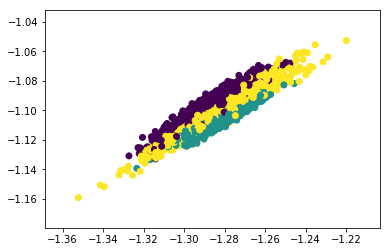

In [15]:
plt.scatter(z1[:, 0], z1[:, 1], c=labels)

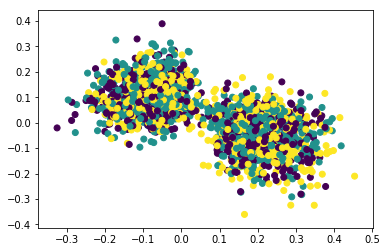

In [16]:
plt.scatter(z2[:, 0], z2[:, 1], c=labels)

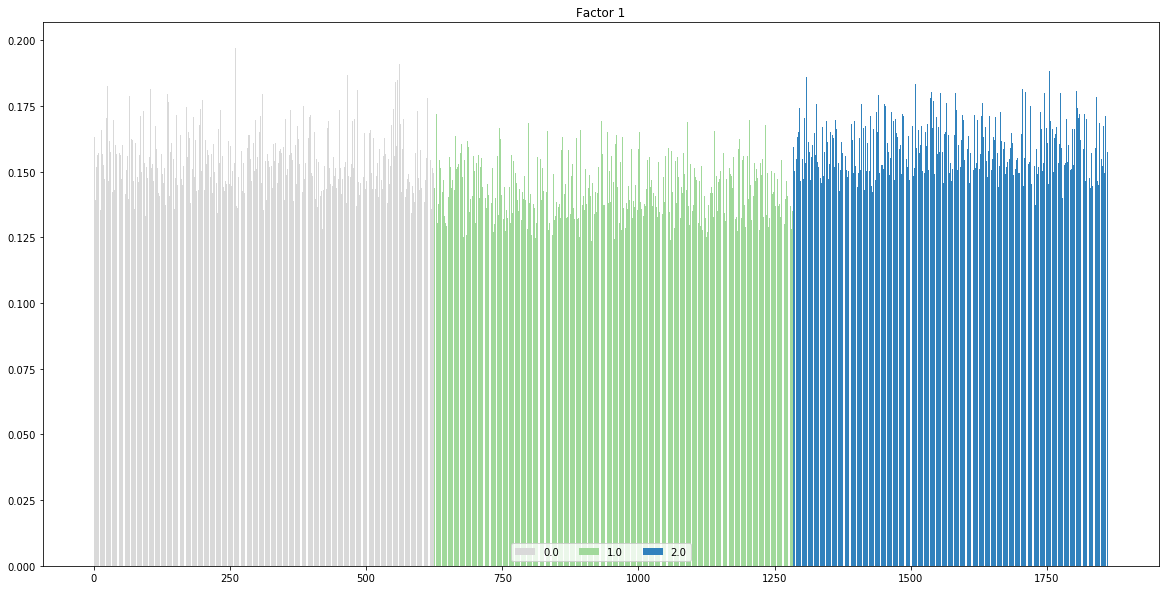

In [11]:
Zs = z1

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

factor_idx    = 1
inds          = np.argsort(labels)
labels_sorted = labels[inds].numpy()
Zs_sorted     = Zs[inds]
zk            = Zs_sorted[:, factor_idx]

cm = plt.cm.get_cmap('tab20c', len(np.unique(labels)))
colors = cm.colors
np.random.shuffle(colors)  # inplace

curr_label = labels_sorted[0]
j = 0
curr_color = colors[j]

labels_added = []

for i, z in enumerate(Zs_sorted):
    if curr_label != labels_sorted[i]:
        curr_label = labels_sorted[i]
        j += 1
        curr_color = cm.colors[j]

    if curr_label not in labels_added:
        labels_added.append(curr_label)
        plt.bar(i, zk[i], color=curr_color, label=curr_label)
    else:
        plt.bar(i, zk[i], color=curr_color)
    
plt.title('Factor %s' % factor_idx)
plt.legend(ncol=4, loc='lower center')